# Huấn luyện mô hình nhận dạng ký tự cho VSLR

Notebook này thực hiện huấn luyện mô hình ResNet50 để nhận dạng 26 ký tự tiếng Việt thông qua cử chỉ tay.

## Các bước thực hiện:
1. Import thư viện và khởi tạo
2. Chuẩn bị dữ liệu
3. Xây dựng mô hình ResNet50
4. Huấn luyện mô hình
5. Đánh giá và lưu mô hình tốt nhất
6. Vẽ biểu đồ kết quả


## 1. Import thư viện và khởi tạo


In [1]:
import os
import sys
import time
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path for imports
sys.path.append(str(Path().resolve().parent.parent.parent))

# Thiết lập matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Using device: cpu
PyTorch version: 2.8.0+cpu
CUDA available: False


## 2. Định nghĩa Dataset và Model


In [2]:
class CharacterDataset(Dataset):
    """Dataset cho ký tự"""
    
    def __init__(self, data_dir: str, transform=None):
        """
        Khởi tạo CharacterDataset
        
        Args:
            data_dir (str): Thư mục dữ liệu
            transform: Transformations
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        
        # Các lớp ký tự
        self.classes = [
            'A', 'B', 'C', 'D', 'DD', 'E', 'G', 'H', 'I', 'K', 'L', 'M', 
            'Mu', 'Munguoc', 'N', 'O', 'P', 'Q', 'R', 'Rau', 'S', 'T', 
            'U', 'V', 'X', 'Y'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Tải dữ liệu
        self.samples = self._load_samples()
        
        print(f"Loaded {len(self.samples)} samples from {len(self.classes)} classes")
    
    def _load_samples(self) -> List[Tuple[str, int]]:
        """Tải danh sách mẫu"""
        samples = []
        
        for class_name in self.classes:
            class_dir = self.data_dir / class_name
            if not class_dir.exists():
                continue
            
            class_idx = self.class_to_idx[class_name]
            
            for img_file in class_dir.glob("*.jpg"):
                samples.append((str(img_file), class_idx))
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Tải ảnh
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [3]:
class CharacterResNet50(nn.Module):
    """ResNet50 model cho nhận dạng ký tự"""
    
    def __init__(self, num_classes: int = 26, pretrained: bool = True):
        """
        Khởi tạo CharacterResNet50
        
        Args:
            num_classes (int): Số lớp
            pretrained (bool): Sử dụng pretrained weights
        """
        super(CharacterResNet50, self).__init__()
        
        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Freeze early layers for transfer learning
        if pretrained:
            for param in self.backbone.parameters():
                param.requires_grad = False
            
            # Unfreeze last few layers
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True
            for param in self.backbone.avgpool.parameters():
                param.requires_grad = True
        
        # Replace the final classifier
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


## 3. Thiết lập tham số và chuẩn bị dữ liệu


In [4]:
# Thiết lập tham số
data_dir = "../../data/characters"
model_dir = "../../trained_models"
batch_size = 32
learning_rate = 0.001
num_epochs = 20
val_split = 0.2

# Tạo thư mục model
os.makedirs(model_dir, exist_ok=True)

print("=== THÔNG TIN THAM SỐ ===")
print(f"Data directory: {data_dir}")
print(f"Model directory: {model_dir}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Number of epochs: {num_epochs}")
print(f"Validation split: {val_split}")
print(f"Device: {device}")


=== THÔNG TIN THAM SỐ ===
Data directory: ../../data/characters
Model directory: ../../trained_models
Batch size: 32
Learning rate: 0.001
Number of epochs: 20
Validation split: 0.2
Device: cpu


In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms created successfully!")


Transforms created successfully!


In [6]:
# Tạo dataset và dataloaders
print("Preparing data...")

# Tạo dataset
full_dataset = CharacterDataset(data_dir, transform=train_transform)

# Chia train/val
val_size = int(len(full_dataset) * val_split)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Tạo val dataset với val transform
val_dataset.dataset.transform = val_transform

# Tạo dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Total samples: {len(full_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")


Preparing data...
Loaded 13000 samples from 26 classes
Train samples: 10400
Validation samples: 2600
Total samples: 13000
Number of classes: 26


## 4. Tạo mô hình và thiết lập training


In [7]:
# Tạo mô hình
print("Creating ResNet50 model...")

model = CharacterResNet50(num_classes=len(full_dataset.classes), pretrained=True)
model = model.to(device)

# Optimizer và scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)
criterion = nn.CrossEntropyLoss()

# In thông tin mô hình
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


Creating ResNet50 model...


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 24,570,458
Trainable parameters: 16,027,162


## 5. Hàm huấn luyện và đánh giá


In [8]:
def train_epoch():
    """Huấn luyện một epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Tính phần trăm hoàn thành
        progress = (batch_idx + 1) / len(train_loader) * 100
        
        if batch_idx % 10 == 0:
            elapsed_time = time.time() - start_time
            print(f'Batch {batch_idx+1}/{len(train_loader)} ({progress:.1f}%), '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%, '
                  f'Time: {elapsed_time:.1f}s')
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, epoch_time

def validate_epoch():
    """Validation một epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # Hiển thị tiến trình validation
            progress = (batch_idx + 1) / len(val_loader) * 100
            if batch_idx % 5 == 0:
                print(f'  Validation: {batch_idx+1}/{len(val_loader)} ({progress:.1f}%)')
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, epoch_time


## 6. Huấn luyện mô hình


In [9]:
# Huấn luyện mô hình
print("Starting training...")

best_val_acc = 0.0
best_epoch = 0
best_model_path = os.path.join(model_dir, "character_model_best.pt")

# Thêm thời gian vào history
history['train_time'] = []
history['val_time'] = []
history['epoch_time'] = []

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc, train_time = train_epoch()
    
    # Validate
    val_loss, val_acc, val_time = validate_epoch()
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Tính thời gian epoch
    epoch_time = time.time() - epoch_start_time
    
    # Lưu history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    history['epoch_time'].append(epoch_time)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% (Time: {train_time:.1f}s)")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% (Time: {val_time:.1f}s)")
    print(f"Epoch Time: {epoch_time:.1f}s")
    
    # Lưu best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'train_loss': train_loss,
            'history': history,
            'best_epoch': best_epoch
        }, best_model_path)
        print(f"🎯 New best model saved! Val Acc: {val_acc:.2f}% (Epoch {best_epoch})")
    
    # Lưu checkpoint sau mỗi epoch
    checkpoint_path = os.path.join(model_dir, f"character_model_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'train_loss': train_loss,
        'history': history
    }, checkpoint_path)
    
    # Ước tính thời gian còn lại
    elapsed_time = time.time() - total_start_time
    avg_epoch_time = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = remaining_epochs * avg_epoch_time
    
    print(f"⏱️  Elapsed: {elapsed_time/60:.1f}min, Estimated remaining: {estimated_remaining_time/60:.1f}min")

# Lưu final model
final_model_path = os.path.join(model_dir, "character_model_final.pt")
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'train_acc': train_acc,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'history': history,
    'best_epoch': best_epoch,
    'best_val_acc': best_val_acc
}, final_model_path)

total_time = time.time() - total_start_time
print(f"\n🎉 Training completed!")
print(f"⏱️  Total training time: {total_time/60:.1f} minutes")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"📁 Best model saved at: {best_model_path}")
print(f"📁 Final model saved at: {final_model_path}")


Starting training...

Epoch 1/20
--------------------------------------------------
Batch 1/325 (0.3%), Loss: 3.2587, Acc: 6.25%, Time: 7.5s
Batch 11/325 (3.4%), Loss: 1.7286, Acc: 26.99%, Time: 69.8s
Batch 21/325 (6.5%), Loss: 1.5755, Acc: 39.88%, Time: 138.3s
Batch 31/325 (9.5%), Loss: 0.5254, Acc: 50.20%, Time: 206.1s
Batch 41/325 (12.6%), Loss: 0.2831, Acc: 58.54%, Time: 272.6s
Batch 51/325 (15.7%), Loss: 0.1904, Acc: 64.89%, Time: 340.0s
Batch 61/325 (18.8%), Loss: 0.4216, Acc: 69.31%, Time: 411.6s
Batch 71/325 (21.8%), Loss: 0.5716, Acc: 72.01%, Time: 480.2s
Batch 81/325 (24.9%), Loss: 0.2480, Acc: 74.19%, Time: 550.9s
Batch 91/325 (28.0%), Loss: 0.1781, Acc: 76.00%, Time: 620.8s
Batch 101/325 (31.1%), Loss: 0.2039, Acc: 77.75%, Time: 689.9s
Batch 111/325 (34.2%), Loss: 0.3368, Acc: 79.19%, Time: 760.4s
Batch 121/325 (37.2%), Loss: 0.0374, Acc: 80.63%, Time: 832.2s
Batch 131/325 (40.3%), Loss: 0.0231, Acc: 82.04%, Time: 905.7s
Batch 141/325 (43.4%), Loss: 0.0407, Acc: 83.20%, Tim

KeyboardInterrupt: 

## 7. Đánh giá mô hình


Loading best model from ../../trained_models\character_model_best.pt

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       110
           B       1.00      1.00      1.00       105
           C       1.00      1.00      1.00        99
           D       1.00      1.00      1.00        97
          DD       1.00      1.00      1.00       107
           E       1.00      0.97      0.98        94
           G       1.00      1.00      1.00       108
           H       0.99      1.00      0.99        95
           I       1.00      1.00      1.00        93
           K       1.00      1.00      1.00        85
           L       0.95      1.00      0.97        96
           M       1.00      1.00      1.00        91
          Mu       1.00      1.00      1.00        86
     Munguoc       1.00      1.00      1.00       114
           N       1.00      1.00      1.00       104
           O       1.00      1.00      1.0

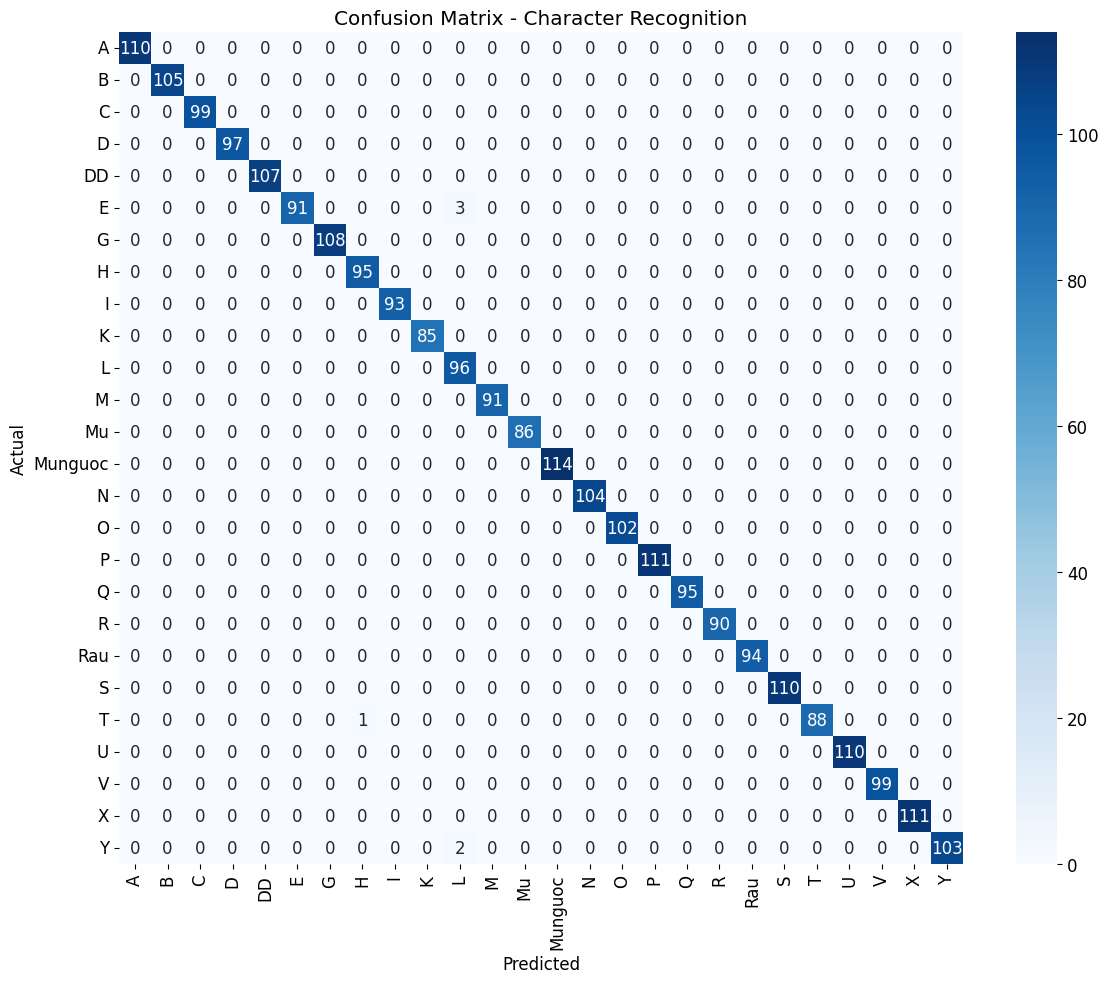

In [10]:
# Đánh giá mô hình tốt nhất
print(f"Loading best model from {best_model_path}")
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = output.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Classification report
class_names = full_dataset.classes

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Character Recognition')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'character_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()


## 8. Vẽ biểu đồ training history


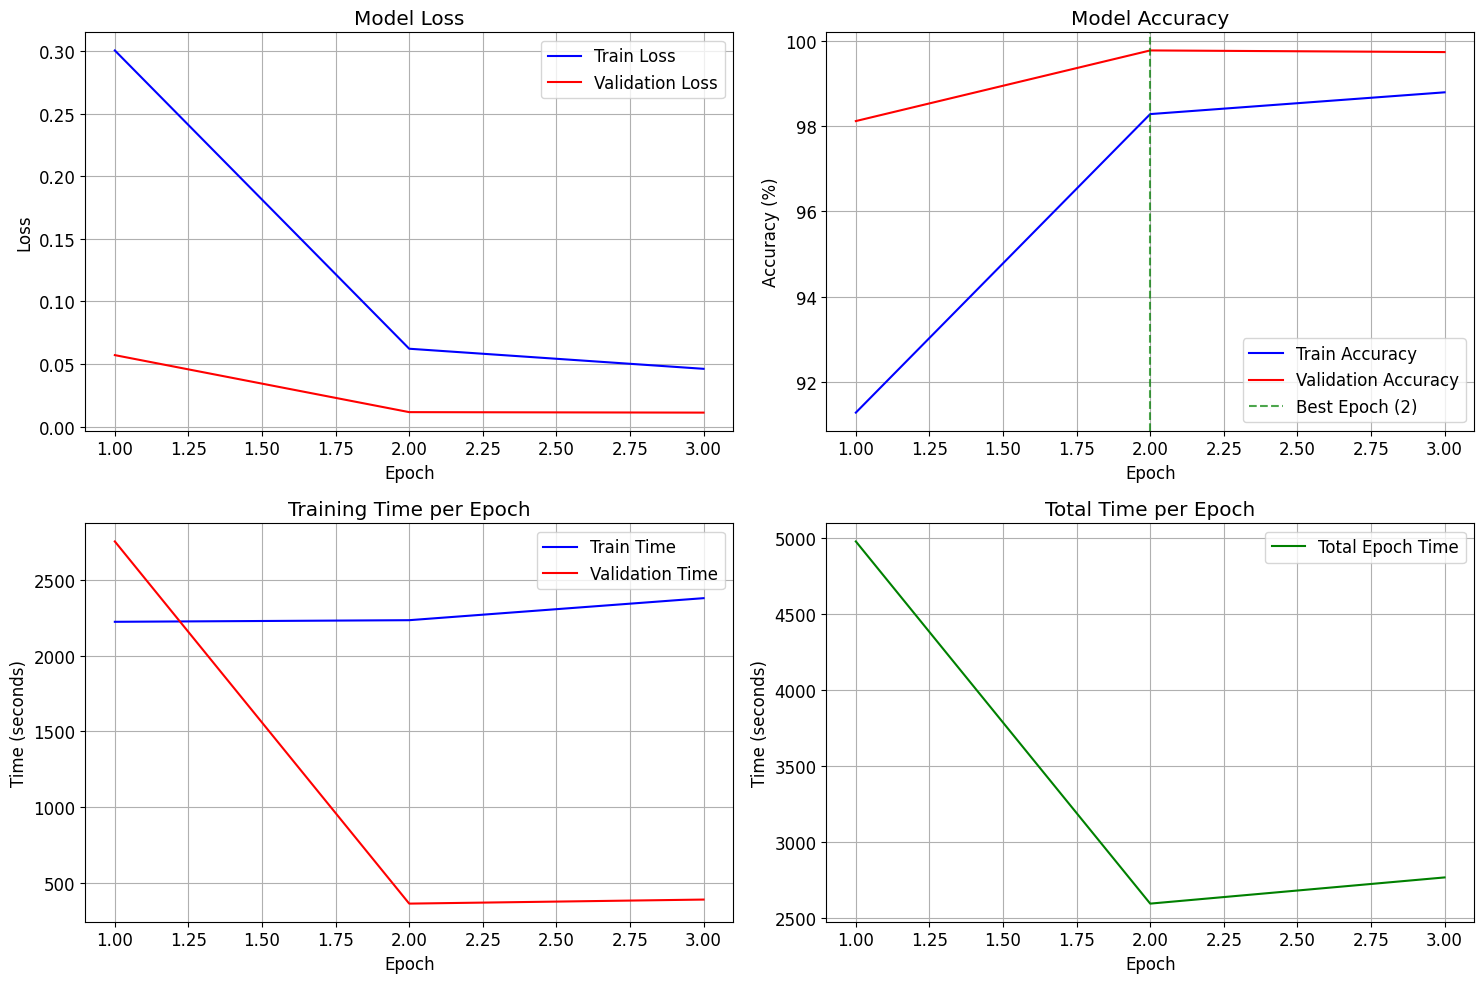


📊 Thống kê thời gian chi tiết:
  - Thời gian training trung bình: 2279.86s ± 71.24s
  - Thời gian validation trung bình: 1168.58s ± 1122.05s
  - Thời gian epoch trung bình: 3448.45s ± 1084.96s
  - Epoch nhanh nhất: 2596.75s (Epoch 2)
  - Epoch chậm nhất: 4979.59s (Epoch 1)


In [11]:
# Vẽ biểu đồ training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss
ax1.plot(epochs, history['train_loss'], label='Train Loss', color='blue')
ax1.plot(epochs, history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(epochs, history['train_acc'], label='Train Accuracy', color='blue')
ax2.plot(epochs, history['val_acc'], label='Validation Accuracy', color='red')
ax2.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch})')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Training Time per Epoch
ax3.plot(epochs, history['train_time'], label='Train Time', color='blue')
ax3.plot(epochs, history['val_time'], label='Validation Time', color='red')
ax3.set_title('Training Time per Epoch')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Time (seconds)')
ax3.legend()
ax3.grid(True)

# Total Epoch Time
ax4.plot(epochs, history['epoch_time'], label='Total Epoch Time', color='green')
ax4.set_title('Total Time per Epoch')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Time (seconds)')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(model_dir, 'character_training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

# In thống kê thời gian
print(f"\n📊 Thống kê thời gian chi tiết:")
print(f"  - Thời gian training trung bình: {np.mean(history['train_time']):.2f}s ± {np.std(history['train_time']):.2f}s")
print(f"  - Thời gian validation trung bình: {np.mean(history['val_time']):.2f}s ± {np.std(history['val_time']):.2f}s")
print(f"  - Thời gian epoch trung bình: {np.mean(history['epoch_time']):.2f}s ± {np.std(history['epoch_time']):.2f}s")
print(f"  - Epoch nhanh nhất: {np.min(history['epoch_time']):.2f}s (Epoch {np.argmin(history['epoch_time'])+1})")
print(f"  - Epoch chậm nhất: {np.max(history['epoch_time']):.2f}s (Epoch {np.argmax(history['epoch_time'])+1})")


## 9. Tóm tắt kết quả


In [12]:
print("=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN MÔ HÌNH KÝ TỰ ===")
print(f"\n📊 Thống kê dữ liệu:")
print(f"  - Tổng số mẫu: {len(full_dataset)}")
print(f"  - Số lớp: {len(full_dataset.classes)}")
print(f"  - Training samples: {len(train_dataset)}")
print(f"  - Validation samples: {len(val_dataset)}")

print(f"\n🤖 Kết quả mô hình:")
print(f"  - Best validation accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"  - Final validation accuracy: {history['val_acc'][-1]:.2f}%")
print(f"  - Best train accuracy: {max(history['train_acc']):.2f}%")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

print(f"\n⏱️  Thống kê thời gian:")
print(f"  - Total training time: {total_time/60:.1f} minutes")
print(f"  - Average epoch time: {np.mean(history['epoch_time']):.1f}s")
print(f"  - Average train time per epoch: {np.mean(history['train_time']):.1f}s")
print(f"  - Average validation time per epoch: {np.mean(history['val_time']):.1f}s")

print(f"\n📈 Training progress:")
print(f"  - Total epochs: {num_epochs}")
print(f"  - Best epoch: {best_epoch}")
print(f"  - Final train loss: {history['train_loss'][-1]:.4f}")
print(f"  - Final validation loss: {history['val_loss'][-1]:.4f}")

print(f"\n💾 Mô hình đã được lưu tại:")
print(f"  - Best model: {best_model_path}")
print(f"  - Final model: {final_model_path}")
print(f"  - Epoch checkpoints: {model_dir}/character_model_epoch_*.pt")
print(f"  - Confusion matrix: {os.path.join(model_dir, 'character_confusion_matrix.png')}")
print(f"  - Training history: {os.path.join(model_dir, 'character_training_history.png')}")

print(f"\n🎯 Bước tiếp theo:")
print(f"  - Sử dụng mô hình trong ứng dụng nhận dạng ký tự")
print(f"  - Hoặc tiếp tục fine-tuning với dữ liệu mới")
print(f"  - Có thể load lại từ epoch bất kỳ: torch.load('character_model_epoch_X.pt')")


=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN MÔ HÌNH KÝ TỰ ===

📊 Thống kê dữ liệu:
  - Tổng số mẫu: 13000
  - Số lớp: 26
  - Training samples: 10400
  - Validation samples: 2600

🤖 Kết quả mô hình:
  - Best validation accuracy: 99.77% (Epoch 2)
  - Final validation accuracy: 99.73%
  - Best train accuracy: 98.79%
  - Total parameters: 24,570,458
  - Trainable parameters: 16,027,162

⏱️  Thống kê thời gian:


NameError: name 'total_time' is not defined